In [1]:
%matplotlib inline
import matplotlib.pyplot as pp
import numpy as np
from scipy import signal
import librosa
import librosa.display
from IPython import display
from copy import deepcopy

# the pra library
import pyroomacoustics as pra

In [2]:
# A simple wrapper class for (1-channel) audio data
# data is a 1-D NumPy array containing the data
# rate is a number expressing the samples per second
class Audio:
    def __init__(self, data, rate):
        self.data = data
        self.rate = rate
    def play(self):
        return display.Audio(self.data, rate=self.rate)
    def plot_wave(self):
        librosa.display.waveplot(self.data, sr=self.rate)
    def plot_spectrum(self):
        n_fft = int(self.rate / 20)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(self.data, n_fft)), ref=np.max)
        librosa.display.specshow(D, y_axis='linear', sr=self.rate, hop_length=n_fft/4)
    @classmethod
    def fromfile(cls, fn):
        return cls(*librosa.load(fn, sr=None))

### Load sound

In [194]:
hello = Audio.fromfile("hello.wav")
print(hello.rate)
print(len(hello.data))
hello.play()

44100
252864


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [195]:
byebye = Audio(Audio.fromfile("byebye.wav").data[:len(hello.data)], hello.rate)
print(len(byebye.data))
byebye.play()

252864


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


## Basic Example

In [196]:
'''Room Parameters and Room Creation'''
rt60 = 0.5 # the time it takes for the room impulse reponse (RIR) to decay by 60dB
room_dim = [10, 10, 10] # meters

# Room is simulated with the "Image Source Model". ISM assumes perfect reflections.
# invert the Sabine's formula to obtain the parameters for the ISM model
e_absorption, max_order = pra.inverse_sabine(rt60, room_dim)
# print(e_absorption, max_order)

# create the room
# fs: sampling rate, max_order: max number of reflections allowed in ISM
room = pra.ShoeBox(room_dim, fs=hello.rate, materials=pra.Material(e_absorption), max_order=max_order)

'''Sound Source Creation'''
room.add_source([7, 1, 3], signal=hello.data)
room.add_source([7, 5, 5], signal=byebye.data[:len(hello.data)])
# room.add_source([7, 9, 8], signal=reverse_sweep, delay=1)

'''Mic Array Creation'''
mic_locs = np.c_[
    [1, 4.9, 5],
    [1, 5, 5],
    [1, 5.1, 5]
]
# place the array in the room
room.add_microphone_array(mic_locs)
# room.add_microphone([1, 5, 5]) # single microphone

'''Simulation'''
room.simulate()
room.mic_array.to_wav(
    "./simu_recv_sound/basic3mic3src.wav",
    norm=True,
    bitdepth=np.int16
)
result = Audio.fromfile("./simu_recv_sound/basic3mic3src.wav")

### Result Inspection

In [199]:
print(len(result.data))
result.play()

284580


## Beamforming

In [295]:
'''Room Parameters and Room Creation'''
room_dim = [10, 10, 10] # meters
m = pra.Material(energy_absorption="panel_fabric_covered_6pcf")
room = pra.ShoeBox(room_dim, fs=hello.rate, materials=m, max_order=0) #simulate perfect situation: no reflections

'''Sound Source Creation'''

room.add_source([7, 1, 3], signal=hello.data)
room.add_source([7, 5, 5], signal=byebye.data[:len(hello.data)])
# room.add_source([7, 9, 8], signal=reverse_sweep, delay=1) # inference 2?

'''Mic Array Creation'''
mic_locs = np.c_[
    [1, 4.5, 5],
    [1, 4.6, 5],
    [1, 4.7, 5],
    [1, 4.8, 5],
    [1, 4.9, 5],
    [1, 5, 5],
    [1, 5.1, 5],
    [1, 5.2, 5],
    [1, 5.3, 5],
    [1, 5.4, 5],
    [1, 5.5, 5]
]

# mic_locs = np.c_[
#     [1, 5, 5], # top right
#     [1, 4.955, 5], # bottom right
#     [0.955, 4.955, 5], # bottom left
#     [0.955, 4.955, 5] # top left
# ]


# filter size (???)
Lg_t = 0.1 # filter size in seconds
Lg = np.ceil(Lg_t*room.fs)


# place the beamforming micarray in the room (the beamforming class is a child class of the micarray class)
fft_len = 512
mics = pra.Beamformer(mic_locs, room.fs, N=fft_len, Lg=Lg)
room.add_microphone_array(mics)

In [296]:
# Compute DAS (delay and sum) weights
mics.rake_delay_and_sum_weights(room.sources[0])


'''Simulation'''
room.compute_rir()
room.simulate()

### Target Sound

In [297]:
hello.play()

### Inference

In [298]:
byebye.play()

### Original_mixed

In [299]:
original_signal = room.mic_array.signals[0, :]
Audio(original_signal, room.fs).play()

### Beamformed

In [300]:
resulted_signal = mics.process()
Audio(resulted_signal, room.fs).play()

### Similarity Evaluation (TODO: we need some kind of normalization)

In [272]:
original_signal = original_signal[:len(hello.data)]
resulted_signal = resulted_signal[:len(hello.data)]

In [273]:
original_signal @ hello.data

-2.2818544856146574

In [274]:
resulted_signal @ hello.data

-0.0073114513087616

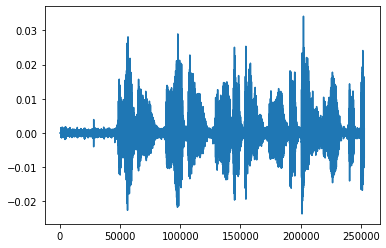

In [275]:
pp.plot(original_signal)